Following the previous post:[pretraining Persian AWD LSTM language model](https://saied71.github.io/RohanAiLab/markdown/2021/07/17/Pretraining-Persian-AWD-LSTM-Language-model.html). Here we finetune our language model that was trained on Persian corpus for sentiment analysis. I use the ULMFIT approach introduced by Jeremy Howard, Sebastian Ruder and implemented it nicely in the fastai library.
for more information about ULMFIT ,and the ideas behind it, you can refer o this post: [Introducing state of the art text classification with universal language models](https://nlp.fast.ai/classification/2018/05/15/introducing-ulmfit.html)

First, we download the model, tokenizer, and the data, which we will use to finetune our language model. after this running this cell, a file named `ULMFIT_FA.zip` will be downloaded, which includes the model, tokenizer, and the data.

In [1]:
%%capture
import gdown
url =  "https://drive.google.com/uc?id=1-VftZs-XxQD6KvmeNT8Io03MU1mQKylO"
output = 'ULMFIT_FA.zip'
gdown.download(url, output, quiet=False)
!unzip ULMFIT_FA.zip
!pip install -U fastai
!pip install sentencepiece

In [1]:
from fastai import *
from fastai.text import *
from fastai.text.all import *
import pandas as pd
import pickle

import fastai
import torch
print(f"fastai version: {fastai.__version__}")
print(f"GPU which is used : {torch.cuda.get_device_name(0)}")

## parameters for dataloader and tokenizer
lang = "fa"
backwards=False
bs=128
vocab_sz = 30000
drop_mult = 0.5
num_workers=18
## setting up the pathes
base = Path(".").absolute()
print(f"our base directory: {base}")
ulmfit_dir = base / "ULMFIT_FA"
print(f"our model and data directory: {ulmfit_dir}")
lm_fns = [ulmfit_dir / f"model_out/{lang}_ULMFIT", ulmfit_dir / f"model_out/{lang}_ULMFIT_vocab"]

fastai version: 2.4.1
GPU which is used : Tesla P100-PCIE-16GB
our base directory: /content
our model and data directory: /content/ULMFIT_FA


This is a preview of the data. I choose Snappfood comment data and going to use it for sentiment analysis of the comments.

In [2]:
df = pd.read_csv(ulmfit_dir / "snapp.csv")
print(f"shape of the data: {df.shape}")
df.sample(5)

shape of the data: (60211, 2)


,comment,label_id
51993,غذا سرد شده و بهم ریخته شده بود برنج‌ها خمیر و قابل خوردن نبود . مخلفات همگی بهم ریخته و نامنظم شده بود و اصلا قیافه خوبی ن داشت سبزی ریحون پخته شده بود .,1
4507,متاسفانه بجای شمع 3 عدد 2 ارسال شده بود,0
25114,واقعا کارتون بیسته دقیق و سریع خدا برکت بده,0
25560,در حدی سرد شده بود ک قابل خوردن نبود,1
59813,کتف مرغ رو اینقدر پودر سوخاری زدن که شده اندازه ران . اونوقت یه تکه هم حسابش کردن . همه چیز گرون شده شما هم گرون کن نه اینکه از سر و ته کار بزنی .,1


leading pretrained SentencePiece for tokenization. Then create a data loader for feeding the language model learner.

In [3]:
tok = SentencePieceTokenizer(lang="fa", max_vocab_sz=vocab_sz, sp_model=ulmfit_dir / "spm/spm.model")

In [4]:
dblock_lm = DataBlock(
    blocks=(TextBlock.from_df('comment', is_lm=True, tok=tok,backwards=False)),
    get_x=ColReader('text'))


dls_lm = dblock_lm.dataloaders(df, bs=bs)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [5]:
dls_lm.show_batch(max_n=4)

,text,text_
0,▁xxbos ▁خیلی ▁تاخیر ▁داشت ▁رسوند ن ▁غذا ▁غذا ▁ها ▁کاملا ▁سرد ▁شده ▁بود ▁و ▁نون ▁ها ▁خمیر ▁xxbos ▁وقتی ▁کیک ▁رسید ▁دستم ▁له ▁له ▁شده ▁شده ▁بود ▁و ▁کاملا ▁از ▁بین ▁رفته ▁بود ▁xxbos ▁خمیر ▁پای ▁سیب ▁ مونده ▁بود ▁. ▁شیرینی ش ▁زیاد ▁بود ▁. ▁مزه ▁شو ▁دوست ▁نداشتم ▁xxbos ▁پیک ▁بسیار ▁مودب ▁و ▁سریع ▁بودن ▁تا ▁پشت ▁در ▁واحد ▁اومدن ▁بالا ▁و ▁تحویل ▁دادن ▁. ▁xxbos ▁بد ▁بود ▁غذاها ▁افتضاح,▁خیلی ▁تاخیر ▁داشت ▁رسوند ن ▁غذا ▁غذا ▁ها ▁کاملا ▁سرد ▁شده ▁بود ▁و ▁نون ▁ها ▁خمیر ▁xxbos ▁وقتی ▁کیک ▁رسید ▁دستم ▁له ▁له ▁شده ▁شده ▁بود ▁و ▁کاملا ▁از ▁بین ▁رفته ▁بود ▁xxbos ▁خمیر ▁پای ▁سیب ▁ مونده ▁بود ▁. ▁شیرینی ش ▁زیاد ▁بود ▁. ▁مزه ▁شو ▁دوست ▁نداشتم ▁xxbos ▁پیک ▁بسیار ▁مودب ▁و ▁سریع ▁بودن ▁تا ▁پشت ▁در ▁واحد ▁اومدن ▁بالا ▁و ▁تحویل ▁دادن ▁. ▁xxbos ▁بد ▁بود ▁غذاها ▁افتضاح ▁تر
1,▁بود ▁خیلی ▁بهتر ▁میشد ▁. ▁xxbos ▁سالاد ▁سزار ▁بدون ▁سس ▁سزار ▁! ▁؟ ▁نمی دونم ▁فراموش ▁کرده ▁بودن ▁بفرست ن ▁یا ▁همیشه ▁همین ه ▁. ▁xxbos ▁باس پاس ▁از ▁کیفیت ▁خوب ▁غذاها ▁، ▁لطفا ▁به ▁منظور ▁صرفه ▁جویی ▁در ▁مصرف ▁کاغذ ▁، ▁منوی ▁کاغذی ▁همراه ▁غذا ▁ارسال ▁نفر ما ی ید ▁. ▁xxbos ▁شیر کا کایو ▁ارسالی ▁فردا ▁من قضی ▁میشود ▁و ▁طعم ▁بدی ▁دارد ▁xxbos ▁پیتزا ▁بیکن ▁فوق ▁الع اد س,▁خیلی ▁بهتر ▁میشد ▁. ▁xxbos ▁سالاد ▁سزار ▁بدون ▁سس ▁سزار ▁! ▁؟ ▁نمی دونم ▁فراموش ▁کرده ▁بودن ▁بفرست ن ▁یا ▁همیشه ▁همین ه ▁. ▁xxbos ▁باس پاس ▁از ▁کیفیت ▁خوب ▁غذاها ▁، ▁لطفا ▁به ▁منظور ▁صرفه ▁جویی ▁در ▁مصرف ▁کاغذ ▁، ▁منوی ▁کاغذی ▁همراه ▁غذا ▁ارسال ▁نفر ما ی ید ▁. ▁xxbos ▁شیر کا کایو ▁ارسالی ▁فردا ▁من قضی ▁میشود ▁و ▁طعم ▁بدی ▁دارد ▁xxbos ▁پیتزا ▁بیکن ▁فوق ▁الع اد س ▁ولی
2,▁. ▁فقط ▁خلال ▁بادام ▁را ▁فراموش ▁کردند ▁xxbos ▁من ▁چندین ▁بار ▁از ▁این ▁نانوایی ▁خرید ▁کردم ▁و ▁همیشه ▁عالی ▁بوده ▁ولی ▁متاسفانه ▁امروز ▁بسی از ▁خمیر ▁بود ▁و ▁اصلا ▁قابل ▁استفاده ▁نبود ▁xxbos ▁متوسط ▁خوب ▁بود ▁، ▁ما ▁دو ▁نفری ▁غذا ▁رو ▁خورد یم ▁تازه ▁زیاد ▁هم ▁اومد ▁، ▁مرسی ▁xxbos ▁فاصله ▁ما ▁خیلی ▁کم ه ▁ولی ▁پول ▁پیک ▁؟ ▁مالیات ▁؟ ▁xxbos ▁متاسف م ▁براتون ▁توی ▁توضیحات ▁نوشت ید ▁جوجه ▁کباب,▁فقط ▁خلال ▁بادام ▁را ▁فراموش ▁کردند ▁xxbos ▁من ▁چندین ▁بار ▁از ▁این ▁نانوایی ▁خرید ▁کردم ▁و ▁همیشه ▁عالی ▁بوده ▁ولی ▁متاسفانه ▁امروز ▁بسی از ▁خمیر ▁بود ▁و ▁اصلا ▁قابل ▁استفاده ▁نبود ▁xxbos ▁متوسط ▁خوب ▁بود ▁، ▁ما ▁دو ▁نفری ▁غذا ▁رو ▁خورد یم ▁تازه ▁زیاد ▁هم ▁اومد ▁، ▁مرسی ▁xxbos ▁فاصله ▁ما ▁خیلی ▁کم ه ▁ولی ▁پول ▁پیک ▁؟ ▁مالیات ▁؟ ▁xxbos ▁متاسف م ▁براتون ▁توی ▁توضیحات ▁نوشت ید ▁جوجه ▁کباب ▁800
3,ه ▁فقط ▁یه ▁مقدار ▁خیلی ▁خیلی ▁کم ▁روش ▁گردو ▁خورد ▁شده ▁ریخته ▁خیلی ▁بیخود ▁بود ▁نسبت ▁به ▁پولی ▁که ▁گرفتن ▁همین ▁سالاد ▁و ▁به ▁اسم ▁سالاد ▁فصل ▁همه ▁جا ▁داره ▁20 ▁تومن ▁میده ▁xxbos ▁عالی ▁بود ▁واقعا ▁. ▁من ▁جایی ▁دیگه ▁پیتزا ▁چان و ▁خوردم ▁ولی ▁پیتزا ی ▁شما ▁باعث ▁شد ▁بفهمم ▁قبلی ا ▁پیتزا ▁نبودن ▁که ▁خوردم ▁. ▁واقعا ▁عالی ▁بود ▁ممنون ▁از ▁شما ▁xxbos ▁آقا ▁ما ▁ساعت ▁10 ▁شب ▁گ,▁فقط ▁یه ▁مقدار ▁خیلی ▁خیلی ▁کم ▁روش ▁گردو ▁خورد ▁شده ▁ریخته ▁خیلی ▁بیخود ▁بود ▁نسبت ▁به ▁پولی ▁که ▁گرفتن ▁همین ▁سالاد ▁و ▁به ▁اسم ▁سالاد ▁فصل ▁همه ▁جا ▁داره ▁20 ▁تومن ▁میده ▁xxbos ▁عالی ▁بود ▁واقعا ▁. ▁من ▁جایی ▁دیگه ▁پیتزا ▁چان و ▁خوردم ▁ولی ▁پیتزا ی ▁شما ▁باعث ▁شد ▁بفهمم ▁قبلی ا ▁پیتزا ▁نبودن ▁که ▁خوردم ▁. ▁واقعا ▁عالی ▁بود ▁ممنون ▁از ▁شما ▁xxbos ▁آقا ▁ما ▁ساعت ▁10 ▁شب ▁گ شن


In [6]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=drop_mult, pretrained=True, pretrained_fnames=lm_fns, 
                               metrics=[accuracy, Perplexity()]).to_fp16()

Using learning rate finder of fastai. Here we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of the learning rate, so we plot with a log scale. Then, we choose a value that is approximately in the middle of the sharpest downward slope.

For more information on the finding the good learning rate you can refer to this post: [how do you find a good learning rate](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)

SuggestedLRs(valley=0.0005754399462603033)

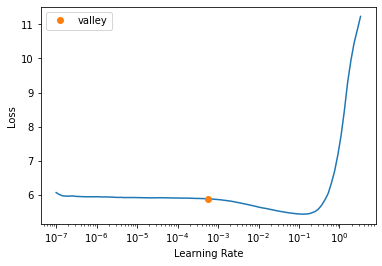

In [ ]:
learn.lr_find()

Next, we finetune the model. By default, a pretrained Learner is in a frozen state, meaning that only the head of the model will train while the body stays frozen.

In [7]:
lr = 1e-3
lr *= bs/48
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.431968,4.142324,0.249683,62.948944,01:39


We can them fine-tune the model after unfreezing

In [8]:
learn.unfreeze()
learn.fit_one_cycle(6, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.061007,3.951483,0.270287,52.012421,01:46
1,3.865995,3.788972,0.287438,44.210945,01:47
2,3.646721,3.685658,0.299375,39.871330,01:47
3,3.451701,3.635723,0.305642,37.929253,01:47
4,3.253018,3.620441,0.308691,37.354046,01:46
5,3.116226,3.625103,0.309143,37.528580,01:46


Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the encoder. We can save it with `save_encoder`

In [9]:
learn.save_encoder(ulmfit_dir / 'finetuned')

Here we gather our data for text classification almost exactly like before:

In [11]:
dblocks_clas = DataBlock(blocks=(TextBlock.from_df('comment', tok=tok, vocab=dls_lm.vocab, backwards=backwards), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('label_id'),
                    )
dls_clas = dblocks_clas.dataloaders(df, bs=bs, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls_clas.show_batch(max_n=4)

,text,category
0,▁xxbos ▁اسنپ ▁مثل ▁همیشه ▁عالی ▁این ▁همه ▁راه ▁رو ▁سریع ▁اومد ▁داغ ▁اورد ▁ولی ▁واقعا ▁از ▁رستوران ▁ایتالیایی ▁مثل ▁شما ▁بعید ه ▁ع ذا تون ▁طعم ▁خوبی ▁نده . ▁قیمت ▁رو ▁شده ▁بالا ▁ببر ین ▁ولی ▁غذا ▁رو ▁خوش ▁طعم ▁درست ▁کنید ▁و ▁باور ▁کنید ▁اگه ▁غذا ▁رو ▁با ▁کیفیت ▁خوب ▁درست ▁کنید ▁باز ▁هم ▁چندین ▁درصد ▁سود ▁میکنید ▁به ▁علاوه ▁این ▁که ▁مشتری ▁بیشتر ▁و ▁بیشتر ▁جذب ▁میکنید ▁اشک لات ▁غذا ▁ ۱ ) ▁خمیر ▁بد ▁طعم ▁و ▁کلفت ▁ ۲ ) ▁پنیر ش ▁واقعا ▁طعم ▁خوبی ▁نمیداد ▁طعم ▁کره ▁میداد ▁ ۳ ) ▁سس ▁بار بیک رو ▁هم ▁نداشت ▁فقط ▁مرغ ▁ها ▁یه ▁مقدار ▁طعم ▁باربیکیو ▁می دادن ▁ ۴ ) ▁چی ▁بگم ▁دیگه ▁حتی ▁روی ▁خمیر ▁هم ▁زیر ▁مواد ▁سس ▁نداشت ▁من ▁از ▁یک ▁دوست xxunk ▁که ▁آشپز ه ▁حرفه ▁ای ▁هست ▁این ▁دستور ▁رو ▁گرفتم ▁تو ▁خونه ▁هم ▁درست ▁کردم ▁طعم ش ▁معر که ▁میشه ▁و,1
1,▁xxbos ▁سلام ▁مثل ▁تمام ▁سفارش ▁های ▁قبلی ▁عالی ▁و ▁بی ▁نظیر ▁بود ▁کدو ▁و ▁بادمجان ▁پیتزا ی ▁سبزیجات ▁به ▁خوبی ▁گریل ▁شده ▁بود ▁و ▁طعم ▁خوبی ▁به ▁پیتزا ▁داده ▁بود ▁و ▁بر ▁خلاف ▁پیتزا ▁های ▁سبزیجات ی ▁که ▁قبلا ▁خورده ▁بودم ▁( xxunk ▁با ▁کدو ▁و ▁بادمجان ) ▁این ▁یکی ▁خیلی ▁طعم ▁بهتری ▁داشت ▁و ▁نظر مو ▁نسبت ▁به ▁استفاده ▁ی ▁کدو ▁و ▁بادمجان ▁در ▁پیتزا ▁عوض ▁کرد ▁و ▁خوشم ▁اومد ▁از ش : ) ؛ ) ▁چی کن ▁چیز ▁هم ▁فوق ▁العاده ▁عالی ▁بود ▁اولین ▁باری ▁بود ▁که ▁امتحان ش ▁میکردم ▁اما ▁از ▁طعم ش ▁خیلی ▁خوشم ▁اومد ▁و ▁به ▁نظرم ▁طعم ▁ ادویه ▁هایی ▁که ▁در ▁تهیه ▁مرغ ش ▁یه ▁کار ▁رفته ▁بود ▁در ▁بقیه ▁مواد ▁و ▁پنیر ش ▁هم ▁پخش ▁شده ▁بود ▁و ▁بی ▁نظیر ▁شده ▁بود ▁یه ▁طعم ▁متفاوت ▁و ▁دوست ▁داشتنی ▁بود ▁که ▁آدم ▁دوست ▁داره ▁همیشه ▁امتحان ش ▁کنه : ) ؛ ) ▁آلپ,0
2,▁xxbos ▁پیشنهاد ▁برای ▁زود ▁فود ▁= ▁در xxunk ▁هایی ▁که ▁برای ▁میزان ▁رضایت ▁از ▁مشتری ▁بکار ▁برد ید ▁یا ▁راضی ▁وجود ▁دارد ▁یا ▁ناراضی ! ▁یعنی ▁یا ▁ ۰ ▁یا ▁ ۱۰۰ ▁xxrep ▁3 ▁! ▁خب ▁اگر ▁کسی ▁بین xxunk ▁رضایت ▁داشت ▁کدوم ▁رو ▁انتخاب ▁کنه ؟ ▁بنظرم ▁متداول ▁بیشتر ▁نظر ▁سنجی ▁ها ▁خوب ▁/ ▁متوسط ▁/ ▁بد ▁میتونه ▁باشه . ▁رضایت ▁من ▁هم ▁از ▁دیزی ▁بهار ▁= ▁متوسط ▁پیاز ▁در ▁بسته ▁بندی ▁نبود ▁که ▁عموما ▁دیزی ▁ها ▁می گذارند . ▁زرد ▁چوب ه ▁اش ▁زیاد ▁بود ▁و ▁خیلی ▁رو ▁طمع ▁تاثیر ▁گذاشته ▁بود . ▁میزان ▁کمی ▁ گوجه ▁و ▁سیب ▁زمینی ▁و ▁نخود ▁لوبیا ش ▁مناسب ▁بود ▁اما ▁هنوز ▁از ▁نظر ▁کیفی ▁کار ▁داشت ▁و ▁دیزی ▁بیشتر ▁جا ▁می افتاد ▁لذیذ ▁تر ▁میشد . ▁نون ▁سنگ ک ▁هم ▁سوختگی ▁اش ▁زیاد ▁بود . ▁خودمون ▁رفتیم ▁از ▁سر کو چه ▁سنگ ک ▁خرید یم ▁تا ▁لذت ▁دیزی ▁خوردن ▁با ▁سنگ,0
3,▁xxbos ▁سلام ▁متاسفانه ▁با ▁توجه ▁به ▁اینکه ▁اصول ا ▁خودم ▁یا xxunk ▁م ▁برای ▁تهیه ▁نون ▁بصورت ▁حضور ▁ی ▁مراجعه ▁می ▁کنیم ▁و ▁با ▁توجه ▁به ▁اینکه ▁اولین ▁بار ▁نیست ▁که ▁نون ▁دو ▁رو ▁کنجد ▁می ▁خرم ▁مقدار ▁کنجد ها ش ▁نسبت ▁به ▁قیمت ▁خیلی ▁کم ▁بود ▁و ▁این ▁همه ▁پول ▁جهت ▁ارسال ▁نون ▁رو ▁اصول ا ▁کمی ▁که ▁از ▁تنور ▁در ▁میارن ▁باد ▁می ▁خوره ▁بعد ▁داخل ▁نایلون ▁می ▁گذارند ▁ولی ▁متاسفانه ▁بدون ▁دلسوز ی ▁جمع ▁آوری ▁نون ▁انجام ▁شده ▁بود ▁وقتی ▁به ▁دستم ▁رسید ▁پلاستیک ▁و ▁نون ▁کاملا ▁خیس ▁بود ▁و ▁حالم ▁رو ▁بد ▁کرد ▁سر جمع ▁راضی ▁نبودم ▁چون ▁هم ▁پول ▁بدی ▁هم ▁ببینی ▁از ▁لحاظ ▁مقدار ▁کنجد ▁بکار ▁برده ▁شده ▁کم ▁بود ▁و ▁هم ▁نون ▁خیس ▁تحویل ▁بگیری ▁خوشم ▁نیومد ▁اولین ▁تجربه ▁= ▁تلخ ▁ضمنا ▁پیشنهاد م ▁به ▁نانوایی ▁ها ▁اینکه ▁چندین ▁کیسه ▁پارچه ▁ای ▁تهیه ▁کنند ▁و ▁برای ▁تحویل ▁نان ▁به ▁مشتری ▁از ▁این ▁گونه,1


The main difference is that we have to use the exact same vocabulary as when we were fine-tuning our language model, or the weights learned won't make any sense. We pass that vocabulary with `vocab`.

Then we can define our text classifier like before:

Defing metrics: we use [accuracy](https://docs.fast.ai/metrics.html#accuracy) and [F1Score](https://docs.fast.ai/metrics.html#F1Score)

In [12]:
metrics=[accuracy,F1Score()]
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=1, pretrained=False, 
                               metrics=metrics).to_fp16()

learn = learn.load_encoder(ulmfit_dir / 'finetuned')
learn.freeze()

SuggestedLRs(valley=tensor(0.0012))

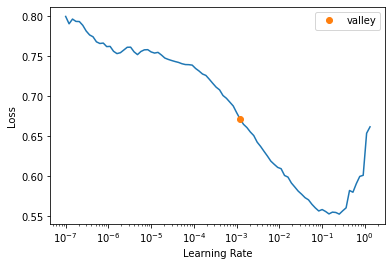

In [ ]:
learn.lr_find()

In [13]:
lr = 1e-3
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.411142,0.329208,0.864807,0.876198,01:39


The last step is to train with discriminative learning rates and gradual unfreezing. In computer vision, we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference.

In [14]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.378707,0.317943,0.867796,0.879321,01:41


In [15]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.375836,0.310461,0.871533,0.881411,01:37


In [16]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.374451,0.309468,0.872197,0.883294,01:39
1,0.360467,0.308152,0.872862,0.882547,01:38


With this approach we got better results than [parsbert](https://github.com/hooshvare/parsbert) on this datset. note that we didn't do so much of preprocesing compare to parsbert finetunning.

You can check out ULMFIT in other languages in this repo: [fastai_ulmfit](https://github.com/floleuerer/fastai_ulmfit), which is an excellent work of Florian.

I really enjoyed working with fastai, and especially this approach, and I hope that others contribute to this project to make it even better.

Here are other useful links :

- [Transfer learning in text](https://docs.fast.ai/tutorial.text.html#The-ULMFiT-approach)
- [Transformers with fastai](https://docs.fast.ai/tutorial.transformers.html)
- [fasthugs](https://github.com/morganmcg1/fasthugs)